In [11]:

from datasets import OpenmlDataset, OpenmlDatasetLoader
from datasets import dataset_train_test_split
from preencoder import PreEncoder 
from models import ToyModel          
from sklearn.metrics import mean_squared_error, accuracy_score
import random
import numpy as np

### example task_ids ###

# 361066 bank-marketing
# 361076 wine_quality
# 361085 sulfur
# 361088 superconduct
# 361089 california
# 361110 electricity
# 361111 eye_movements
# 361112 KDDCup09_upselling
# 361114 rl
# 361116 compass
# 361099 Bike_Sharing_Demand
# 361102 house_sales
# ,361076,361085,361088,361089,361110,361111,361112,361114,361116, 361099,361102


# Num encoding PLE ENCODING memory error for { 361088 (79 features); Aggregation: feature; force_independence: True;} 
# Probleme aussi quand il y'a des features categorielles pour PLE EMBEDDING

# issues with dataset 361112

""" Faire deja les experiments et recolter les résultats 
- Pour chaque dataset, pour chaque méthode de pre-encoding, pour chaque méthode de pre-encoding, pour chaque taille d'embedding,
- Faire une moyenne des résultats pour chaque dataset
- Faire une moyenne des résultats pour chaque méthode de pre-encoding
- Faire une moyenne des résultats pour chaque taille d'embedding

 """
#[361066,361076,361085,361088,361089,361110,361111,361112,361114,361116,361099,361102]
#class [361066,361110,361112,361116] 
#regr [361076, 361089, 361099, 361102]

ids = [361066,361110,361112,361116]

#aggregation_method = ["feature","sample"]
#["baseline","numEncoder_Encoding","feature2vec"]

method = ["feature2vec"]
random_seeds = [42, 123, 456, 789, 101112]
emb_size = [8,20,50,100,180,200]

relative_perf ={}
results = {}
std = {}

for task_id in ids :
    

    dataset_loader = OpenmlDatasetLoader()
    dataset = dataset_loader.load(task_id)
    dataset.print_info()

    results[dataset.name] = {}
    std[dataset.name] = {}

    for m in method : 

        performances = []

        for seed in random_seeds:

            random.seed(seed)
            np.random.seed(seed)
            
            dataset_train, dataset_test = dataset_train_test_split(dataset, frac=0.7,seed_value=seed)

            preencoder = PreEncoder(method=m)
            preencoder.fit(dataset_train)
            
            dataset_train, dataset_val = dataset_train_test_split(dataset_train, frac=0.7,seed_value=seed)

            aggregation = 'feature'

            force_independence = False
            
            """ if m == "feature2vec" :
                force_independence = False
            else:
                force_independence = True """


            X_train, y_train = preencoder.transform(dataset_train, aggregation=aggregation, force_independence=force_independence)
            X_val, y_val = preencoder.transform(dataset_val, aggregation=aggregation, force_independence=force_independence)
            X_test, y_test = preencoder.transform(dataset_test, aggregation=aggregation, force_independence=force_independence)


            #dataset_train.print_info()
            #dataset_val.print_info()
            #dataset_test.print_info()

            model = ToyModel(task = dataset.task, 
                            n_epochs = 50, 
                            network = aggregation, 
                            m_features = len(dataset.categorical_indicator), 
                            h_dim=256, 
                            early_stopping=False)

            model.fit(X_train, y_train, X_val, y_val)

            #prediction and evaluation
            y_pred = model.predict(X_test)

            #different evaluation metrics 
            if dataset.task == "classification":
                accuracy = accuracy_score(y_test, y_pred)
                performances.append(accuracy*100)
            else:
                rmse = mean_squared_error(y_test, y_pred, squared=False)
                performances.append(rmse)
        std[dataset.name][m] = round(np.std(performances),3)
        results[dataset.name][m] = round(np.mean(performances),3)


#Evaluation. For each tuned configuration, we run 15 experiments with different random seeds and report the average performance on the test set.

-------------------------------
Dataset name: bank-marketing
n_samples: 10578
m_features: 7 (including 0 categorical features)
Task: classification
-------------------------------
Iter 0: Negative Sampling Loss = 53.3724
Iter 50: Negative Sampling Loss = 0.1017
Iter 100: Negative Sampling Loss = 0.0166
Iter 150: Negative Sampling Loss = 0.0108
Iter 200: Negative Sampling Loss = 0.0082
Iter 250: Negative Sampling Loss = 0.0057
Epoch :10 | Train loss: 0.518| Val loss: 0.520
Epoch :20 | Train loss: 0.516| Val loss: 0.518
Epoch :30 | Train loss: 0.513| Val loss: 0.524
Epoch :40 | Train loss: 0.512| Val loss: 0.517
Epoch :50 | Train loss: 0.511| Val loss: 0.519
Iter 0: Negative Sampling Loss = 53.3723
Iter 50: Negative Sampling Loss = 0.1292
Iter 100: Negative Sampling Loss = 0.0249
Iter 150: Negative Sampling Loss = 0.0124
Iter 200: Negative Sampling Loss = 0.0090
Iter 250: Negative Sampling Loss = 0.0063
Epoch :10 | Train loss: 0.529| Val loss: 0.510
Epoch :20 | Train loss: 0.525| Val los

In [16]:
std

{'bank-marketing': {'feature2vec': 0.232},
 'electricity': {'feature2vec': 0.584},
 'KDDCup09_upselling': {'feature2vec': 1.074},
 'compass': {'feature2vec': 0.652}}

In [17]:
results

{'bank-marketing': {'feature2vec': 76.338},
 'electricity': {'feature2vec': 76.981},
 'KDDCup09_upselling': {'feature2vec': 74.265},
 'compass': {'feature2vec': 68.28}}

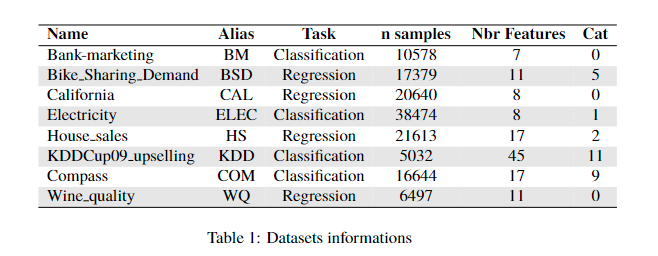

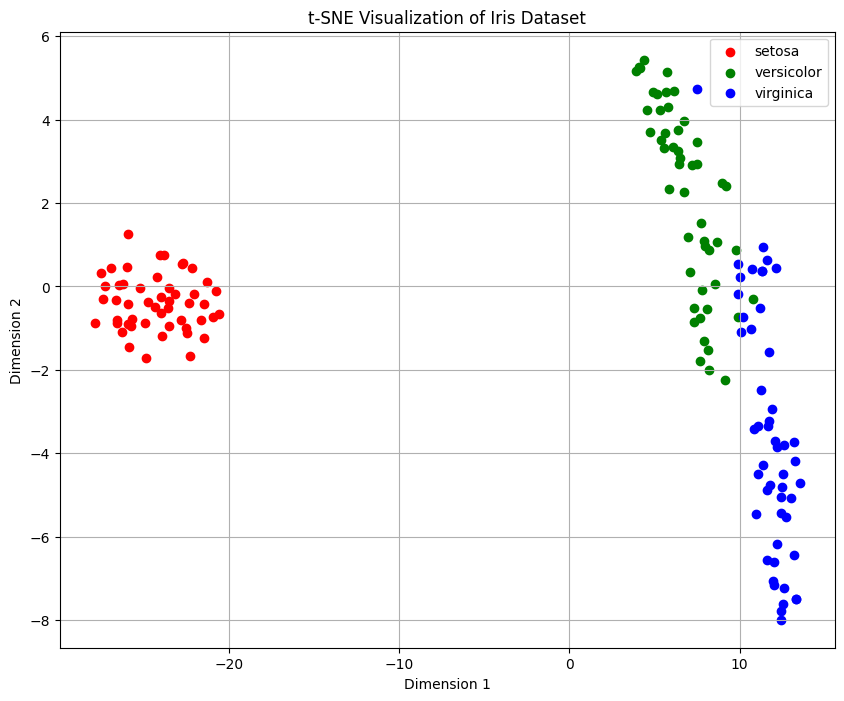

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.manifold import TSNE

# Charger le dataset Iris
iris = load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

# Réduire la dimensionnalité avec t-SNE
tsne = TSNE(n_components=2, random_state=42, init='pca', perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X)

# Plot t-SNE
plt.figure(figsize=(10, 8))
colors = ['r', 'g', 'b']
for i, c, label in zip(range(len(target_names)), colors, target_names):
    plt.scatter(X_tsne[y == i, 0], X_tsne[y == i, 1], c=c, label=label)
plt.title('t-SNE Visualization of Iris Dataset')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
X.shape

(150, 4)